# Part 6 - Google Trends data

- toc: True
- badges: true
- comments: true
- categories: [jupyter]

In this notebook I will describe my code to download data from Google trends 
as well as code to pull *keyword suggestions" based on some *seed* keywords.

I start in the usual way I do with all my notebooks with
* imports
* print version for Python and non standar modules

This boilerplate code is evolving and hopefully getting better

In [1]:
import os
import sys
import datetime
import inspect
import pandas as pd
import plotnine as pn
import pytrends as pt
from pytrends.request import TrendReq
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
vi = sys.version_info
print("version {0}.{1}.{2} of Python".format(vi.major, vi.minor, vi.micro))

version 3.9.2 of Python


In [2]:
#notebook formatting things
from IPython.display import display, HTML
display(HTML("<style>div.output_scroll { height: 60em; }</style>"))
# This changes the width of the coding area
display(HTML("<style>.container { width:95% !important; }</style>"))
# this will make pandas show all columns, using a slider
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 60)

In [3]:
def get_import_versions():
  import sys, inspect
  mlist = list(filter(lambda x: inspect.ismodule(x[1]), globals().items()))
  tups = []
  for name, mod in mlist:
      mname = name
      if name.startswith("__"):
          continue
      if hasattr(mod, "__version__"):
          mname = name
          if hasattr(mod, "__path__"):
              mname = os.path.split(mod.__path__[0])[1]
          tups.append((mname, name, mod.__version__))
          #print("version {1} of {0} as {2} ".format(mname, name, mod.__version__))
      elif hasattr(mod, "__file__") and "site-packages" in mod.__file__:
        ver = None
        tups.append((mname, name, ver))
        #print("No __version__ for {0} as {1}".format(mname, name))
  df = pd.DataFrame(tups, columns=["module", "asname", "version"])
  return df
vdf = get_import_versions()
vdf

,module,asname,version
0,pandas,pd,1.2.3
1,plotnine,pn,0.7.1
2,pt,pt,None
3,matplotlib,mpl,3.3.4
4,plt,plt,None
5,numpy,np,1.20.1


In [4]:
end_date = datetime.date.today()
start_date = end_date - datetime.timedelta(weeks=52*8)
print("start dt {0},  end_dt {1}".format(start_date, end_date))

start dt 2013-11-11,  end_dt 2021-11-01


## Pytrends api
I'm new to pytrends but I'll make a go of using it.

Seems like the steps are
* create a *TrendReq* object which is usually called *pytrends*.
* configure the TrendReq object, called pytrends, by calling *build_payload* with pytrends with parameters for 
  - a keyword list
  - a timeframe
  - a geography reference
* call *interest_over_time* to get the data, returns a dataframe
 
It will be useful to wrap some of the code that sets up the paramaters for  ***build_payload*** into a function

I'll call the function *set_payload*

In [5]:
def set_payload_weeks(trend_req, kw_list, nweeks=100, geo='US', cat=60, grop=''):
    end_date = datetime.date.today()
    start_date = datetime.date.today() - datetime.timedelta(weeks=nweeks)
    timeframe = start_date.strftime("%Y-%m-%d") + " " + end_date.strftime("%Y-%m-%d")  
    trend_req.build_payload(kw_list, cat=cat, timeframe=timeframe, geo=geo, gprop=grop)    
    return trend_req

def make_trend_req(kw_list, cat=60, geo='US', grop=''):
    trend_req.build_payload(kw_list, cat=cat, geo=geo, gprop=grop) 
    return trend_req

def set_payload_start_end(trend_req, kw_list, start_date, end_date, geo='US', cat=60, grop=''):
    timeframe = start_date.strftime("%Y-%m-%d") + " " + end_date.strftime("%Y-%m-%d")  
    trend_req.build_payload(kw_list, cat=cat, timeframe=timeframe, geo=geo, gprop=grop)    
    return trend_req  


In [6]:
# find default freq
# Google trends adjusts the frequency of the returned data to the 
#  time span requested.
# asking for a week gives daily, 8 months weekly, et cetera
# this snippet is intended to finc the freq for different spans
from collections import defaultdict
fdict = {}
last_freq = 10
tups = []
end = datetime.date.today()
starts = [end - datetime.timedelta(days=3),
  end - datetime.timedelta(weeks=1),
  end - datetime.timedelta(weeks=3),          
  end - datetime.timedelta(weeks=4),
  end - datetime.timedelta(weeks=5),     
  end - datetime.timedelta(weeks=4*8),  
  end - datetime.timedelta(weeks=4*9),   
  end - datetime.timedelta(weeks=4*10),           
  end - datetime.timedelta(weeks=52),
  end - datetime.timedelta(weeks=52*4),
  end - datetime.timedelta(weeks=52*5),
  end - datetime.timedelta(weeks=52*6)]

for start in starts:
  #print(start)
  tr = TrendReq(hl='en-US', tz=360)
  tr = set_payload_start_end(trend_req=tr, kw_list=['work'], cat=60, start_date=start, end_date=end, geo='US', grop='')
  df = tr.interest_over_time()
  rows = df.shape[0]
  days = (end-start).days
  tups.append((start, end, days, rows))

x = pd.DataFrame(tups, columns=["start", "end", "days", "rows"])
x["weeks"] = x["days"]/7.0
x["months"] = x["days"] / 30
x["years"] = x["days"] / 365
x["rows_week"] = x["rows"]/x["weeks"]
x

,start,end,days,rows,weeks,months,years,rows_week
0,2021-10-29,2021-11-01,3,2,0.428571,0.100000,0.008219,4.666667
1,2021-10-25,2021-11-01,7,6,1.000000,0.233333,0.019178,6.000000
2,2021-10-11,2021-11-01,21,20,3.000000,0.700000,0.057534,6.666667
3,2021-10-04,2021-11-01,28,27,4.000000,0.933333,0.076712,6.750000
4,2021-09-27,2021-11-01,35,34,5.000000,1.166667,0.095890,6.800000
5,2021-03-22,2021-11-01,224,223,32.000000,7.466667,0.613699,6.968750
6,2021-02-22,2021-11-01,252,251,36.000000,8.400000,0.690411,6.972222
7,2021-01-25,2021-11-01,280,39,40.000000,9.333333,0.767123,0.975000
8,2020-11-02,2021-11-01,364,51,52.000000,12.133333,0.997260,0.980769
9,2017-11-06,2021-11-01,1456,207,208.000000,48.533333,3.989041,0.995192


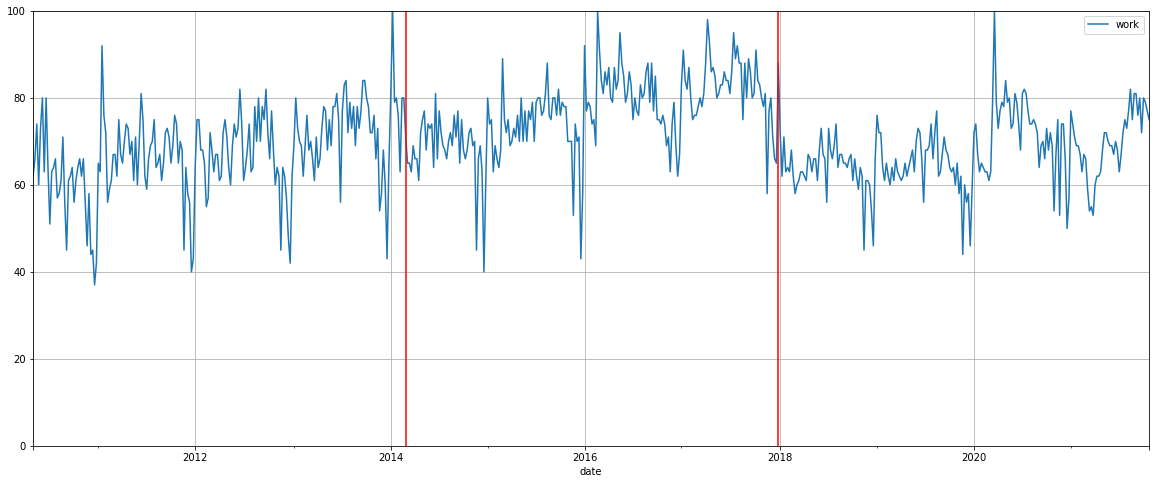

In [7]:
def trends_get_weekly(trend_req, kw_list,  start, end, cat=60,  geo="US", grop='', return_windows=False, verbosity=0):
  if verbosity > 0:
    print("start {0}  end {1}".format(start, end))
  windows = [(start, end)]
  if (end - start).days > 360*4.8:
    windows = []
    starts = []
    st = end - datetime.timedelta(weeks=50*4)
    while end > start:
      new_w = (st, end)
      if verbosity > 0:
        print("adding to windows {0}".format(new_w))
      windows.append(new_w)
      end = st - datetime.timedelta(days=1)
      st = end - datetime.timedelta(weeks=50*4)
      if verbosity > 1:
        print(st, end)
  if verbosity > 0:
    print("windows {0}".format(windows))
  res = pd.DataFrame()
  for start, end in windows:
    if verbosity > 0:
      print(start, end)
    tr = TrendReq(hl='en-US', tz=360)
    tr = set_payload_start_end(trend_req=tr, kw_list=kw_list, cat=cat, start_date=start, end_date=end, geo='US', grop='')
    df = tr.interest_over_time()  
    if res.shape[0] == 0:
      res = df
    else:
      res = pd.concat([res, df])
  if return_windows:
    return res, windows
  else:
    return res
  
tr = TrendReq(hl='en-US', tz=360)
df, windows = trends_get_weekly(trend_req=tr, kw_list=['work'], cat=60, start=start_date, end=end_date, geo="US", grop='', return_windows=True, verbosity=0)
df.sort_index(inplace=True)
ax = df.plot(y="work", figsize=[20,8], ylim=[0,100], grid=True)
for w in windows:
  ax.axvline(w[1], color="red")

I don't know what *isPartial* means yet.  The module documentation does not say much about it.
I read somewere *You can ignore isPartial for now: that field lets you know if the data point is complete for that particular date*, so I plan to remove an ignore it.
Now let's try with more keywords and plot the results

<AxesSubplot:xlabel='date'>

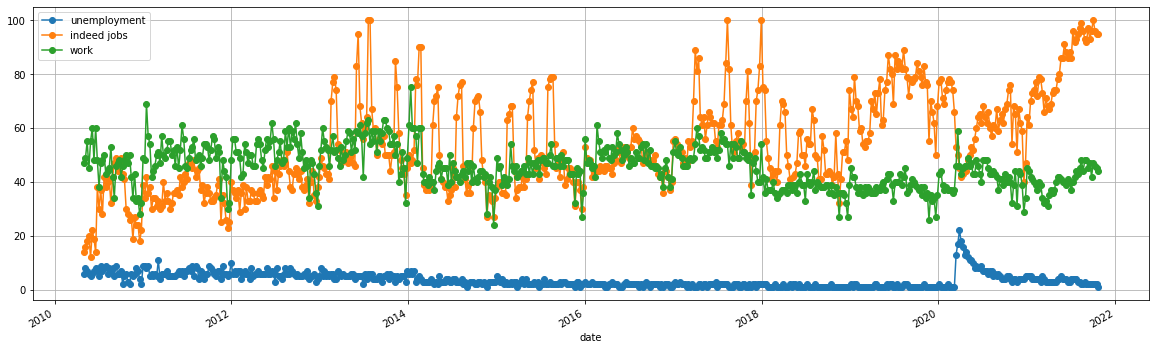

In [8]:
kw_list = [ "unemployment", "indeed jobs", "work"] #  "monster jobs"] #, "work"]
tr = TrendReq(hl='en-US', tz=360)
df = trends_get_weekly(trend_req=tr, kw_list=kw_list, cat=60, start=start_date, end=end_date, geo="US", grop='')
df.plot(figsize=[20,6], grid=True, marker='o')

Notes
* the resulting data is weekly. I have read that that is the standard when the time span is over 90 days.
* There is a *get_daily_data* method available in the pytrends module but I ok with weekly for now.


## Getting More keywords
OK, so far so good.  Maybe using more keywords would give us better preictor variables, but what other keywords might be useful.  The trend_requst object gives 2 methods that seem like they might help here
* relate_queries
* suggestions
I'm not sure the difference but for now I am usig related_queries.
It returns a *score* which I belive is some measure of how related the other query is.
Below I have some code to do the following
* start with some seed queries, push then into a queue
* pop an item off the queue, an item includes a keyword and a score
* if the score is above a threshold 
 - add the keyword to the keyword list
 - call *related queries* on the keyword and push all results above a cutoff into the queue

In [9]:
from collections import deque
import time

sleeptime = 0.0001
verbosity = 1
max_keywords = 30
min_score = 99

keywords2try = deque()
keyword_tups = deque()
keyword_set = set()

# seed the queue with a few terms
keywords2try.appendleft(("jobs", 101, 0, 'root', 101))
#keywords2try.appendleft(("unemployment", 101, 0, 'root', 101))
keywords2try.appendleft(("work", 101, 0, 'root', 101))
keywords2try.appendleft(("indeed jobs", 101, 0, 'root', 101))
print("Start {0}".format(datetime.datetime.now()))
while len(keywords2try) > 0:
    if len(keyword_tups) > max_keywords:
        break
    kw, score, level, parent, parent_score = keywords2try.pop()
    if kw in keyword_set:
        if verbosity > 1:
            print("{0} already in set".format(kw))
        continue
    if verbosity > 0:
        print("<kw#{1}='{0}''>, ".format(kw, len(keyword_tups)+1), end='')
    # add to keyword_tups and keyword_set
    keyword_tups.appendleft((kw, score, level, parent, parent_score))
    keyword_set.add(kw)
    
    trend_req = TrendReq(hl='en-US', tz=360)    
    tr = TrendReq(hl='en-US', tz=360)    
    trend_req = make_trend_req(kw_list=[kw], cat=60, geo='US', grop='')    
    #trend_req = set_payload(trend_req, kw_list=[kw])
    # do I need to insert some wait time here?
    time.sleep(sleeptime)
    try:
        related = trend_req.related_queries()
    except Exception as e:
        last_exception = e
        exc_type, exc_obj, exc_tb = sys.exc_info()
        related = "error"
        break        
    if not related:
        if verbosity > 1:
            print("\t No related")
        continue
    if 'top' not in related[kw].keys():
        if verbosity > 1:
            print("\tNo top")
        continue
    df = related[kw]['top']
    if df is None:
        if verbosity > 1:
            print("\ttop is empty")
        continue
    for tup in df.itertuples():
        child_score = score * tup.value/float(100)
        if child_score > min_score and tup.query not in keyword_set:
            if verbosity > 1:
                print("\tpushing {0}".format(tup.query))
            keywords2try.appendleft((tup.query, child_score, level+1, kw, score))
if related == "error":
    import traceback
    traceback.print_tb(exc_tb)
    fname = os.path.split(exc_tb.tb_frame.f_code.co_filename)[1]
    print(exc_type, fname, exc_tb.tb_lineno)  
    raise Exception(last_exception)
print("Done {0}".format(datetime.datetime.now()))
kw_df = pd.DataFrame(data=list(keyword_tups), columns=['keyword', 'score', 'level','parent', 'parent_score']).sort_values(by="score", ascending=False)
kw_df.sort_values(by='score', ascending=True)
kw_df.tail(20)

Start 2021-11-01 14:49:50.330499
<kw#1='jobs''>, <kw#2='work''>, <kw#3='indeed jobs''>, <kw#4='jobs near me''>, <kw#5='work from home''>, <kw#6='jobs indeed near me''>, <kw#7='jobs near me hiring''>, <kw#8='work from home jobs''>, <kw#9='jobs hiring near me indeed''>, <kw#10='part time jobs hiring''>, <kw#11='hiring jobs near me part time''>, <kw#12='work from home amazon jobs''>, <kw#13='work from home amazon''>, <kw#14='now hiring near me''>, <kw#15='hiring jobs near me''>, <kw#16='hiring near me''>, <kw#17='part time hiring near me''>, <kw#18='job hiring near me''>, <kw#19='amazon careers''>, <kw#20='amazon jobs work from home''>, <kw#21='amazon jobs''>, <kw#22='jobs now hiring''>, <kw#23='jobs hiring near me''>, <kw#24='amazon jobs careers''>, <kw#25='amazon jobs near me''>, <kw#26='now hiring jobs near me''>, <kw#27='amazon jobs near me hiring''>, <kw#28='part time jobs hiring now near me''>, <kw#29='part time jobs near me that are hiring now''>, Done 2021-11-01 14:50:35.182587


,keyword,score,level,parent,parent_score
23,jobs indeed near me,101.00,1,indeed jobs,101.00
24,work from home,101.00,1,work,101.00
5,amazon jobs careers,101.00,5,amazon careers,101.00
25,jobs near me,101.00,1,jobs,101.00
26,indeed jobs,101.00,0,root,101.00
27,work,101.00,0,root,101.00
16,work from home amazon,101.00,3,work from home jobs,101.00
18,hiring jobs near me part time,99.99,3,jobs near me hiring,101.00
0,part time jobs near me that are hiring now,99.99,7,part time jobs hiring now near me,99.99
1,part time jobs hiring now near me,99.99,6,now hiring jobs near me,99.99


In [10]:
print("Found {0} queries".format(kw_df.shape[0]))
kw_df.sort_values(by="score", inplace=True)
out_dir = "./data"
if not os.path.isdir(out_dir):
    os.mkdir(out_dir)
try:
    kw_df.to_csv(os.path.join(out_dir, "google_keywords.txt"))
except Exception as exc:
    print(exc)
    raise(exc)

Found 29 queries


In [11]:
trend_req = TrendReq(hl='en-US', tz=360)
nyears = 10
trendsdf = pd.DataFrame()
print(start_date)
for i, tup in enumerate(kw_df.itertuples()):
    print(" {0} of {1}, {2}".format(i, kw_df.shape[0], tup.keyword))
    trend_req = make_trend_req(kw_list=kw_list, cat=60, geo='US', grop='') 
    tempdf = trends_get_weekly(trend_req=tr, kw_list=[tup.keyword], cat=60, start=start_date, end=end_date, geo="US", grop='', verbosity=0)
    tempdf.drop('isPartial', axis=1, inplace=True)
    if trendsdf.shape[0] == 0:
        trendsdf = tempdf
    else:
        trendsdf = trendsdf.join(tempdf, how="outer")
trendsdf.sort_index(inplace=True)
print(trendsdf.columns)
display(trendsdf.head(2))

2013-11-11
 0 of 29, hiring jobs near me
 1 of 29, now hiring jobs near me
 2 of 29, amazon jobs near me
 3 of 29, jobs hiring near me
 4 of 29, jobs now hiring
 5 of 29, amazon jobs
 6 of 29, job hiring near me
 7 of 29, part time hiring near me
 8 of 29, hiring near me
 9 of 29, part time jobs hiring now near me
 10 of 29, part time jobs near me that are hiring now
 11 of 29, hiring jobs near me part time
 12 of 29, amazon jobs near me hiring
 13 of 29, work from home amazon
 14 of 29, jobs
 15 of 29, jobs near me
 16 of 29, amazon jobs careers
 17 of 29, work from home
 18 of 29, jobs indeed near me


ResponseError: The request failed: Google returned a response with code 429.

In [ ]:
xcol = "date"
title = "title"
df = trendsdf.copy()

ycols = [c for c in df.columns if c != "date"]
sharex = False
ncols=4
figwd=30
fight=40
xtick_rot = 45
ylim=(None, None)
nrows = int(np.ceil(len(ycols)/float(ncols)))
fig = None
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=[figwd, fight], sharex=sharex)  
print(axs.shape)
for i, ycol in enumerate(ycols):
  if ycol == "date":
    continue
  row = i // ncols
  col = i % ncols
  ax = axs[row][col]  

  df.iloc[-200:].plot(ax=ax, kind='line', y=ycol,linestyle='-', marker='o', lw=1, ylim=ylim,
                   mec='red', mfc='black', ms=0.85,  title=None, legend=None, label=None, grid=True, sharex=True)

  ax.text(.5,.9, ycol,
        horizontalalignment='center',
        transform=ax.transAxes)  
    
  ax.xaxis.set_tick_params(rotation=xtick_rot)     

plt.show()

In [ ]:
print(trendsdf.shape)
print(trendsdf.head(2))
print(datetime.datetime.now())

In [ ]:
try:
    out_dir = "./data"
    if not os.path.isdir(out_dir):
        os.mkdir(out_dir)
    trendsdf.sort_index()  
    trendsdf.to_csv(os.path.join(out_dir, "google_trends.csv"))
except Exception as exc:
    print(exc)
    raise Exception(exc)

In [ ]:
import datetime
print(datetime.datetime.now())